[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 3475, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.98       496
     Suspect       0.97      0.99      0.98       497
Pathological       0.99      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      149

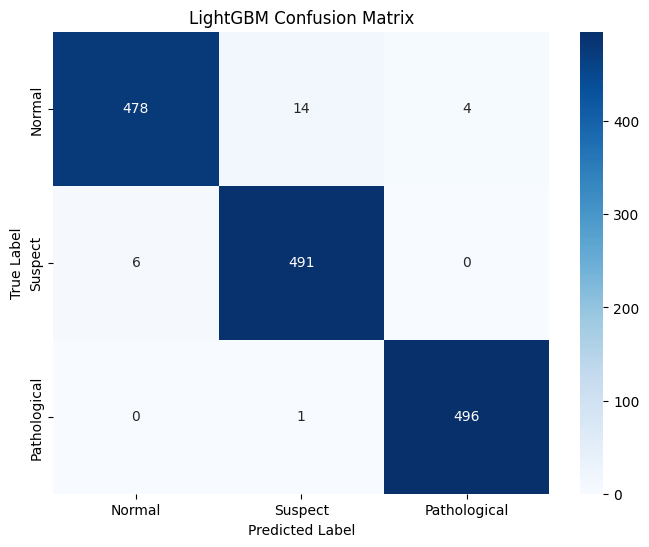


Random Forest Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       496
     Suspect       0.96      0.99      0.97       497
Pathological       0.99      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490

Random Forest Execution Time: 0.84 seconds


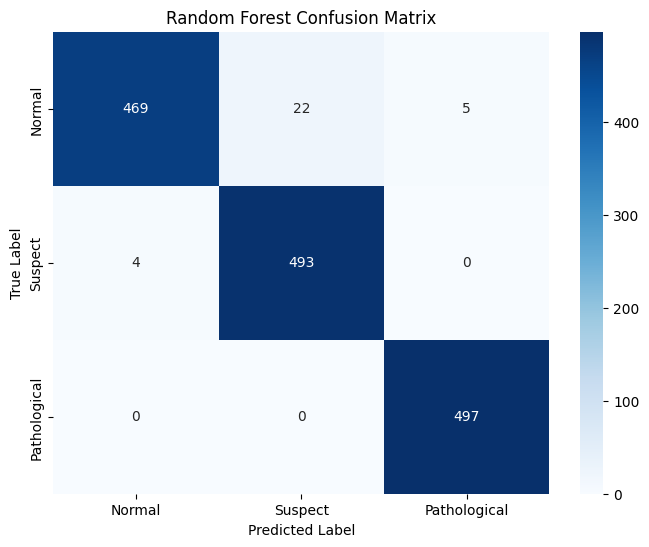

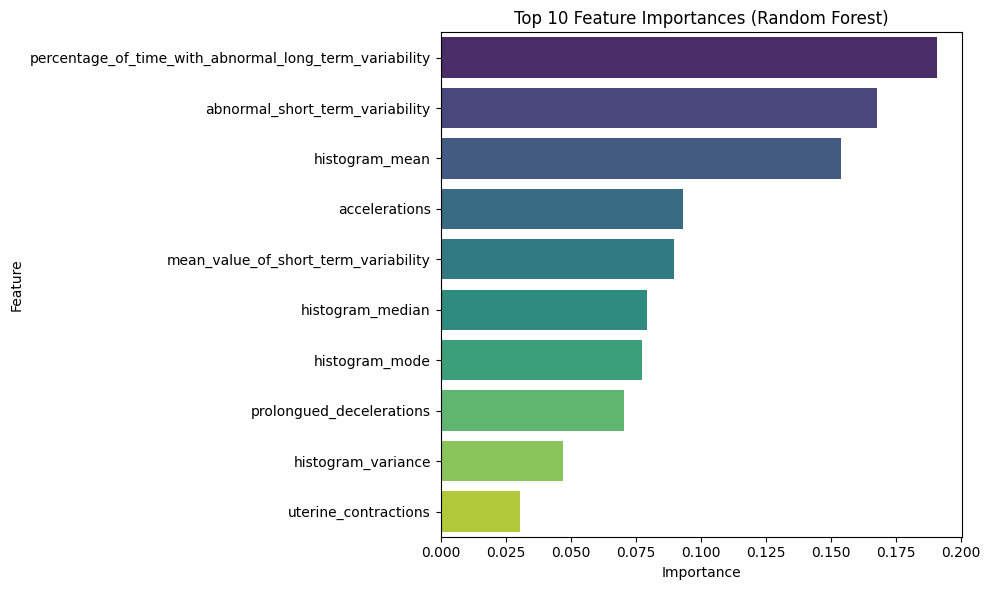

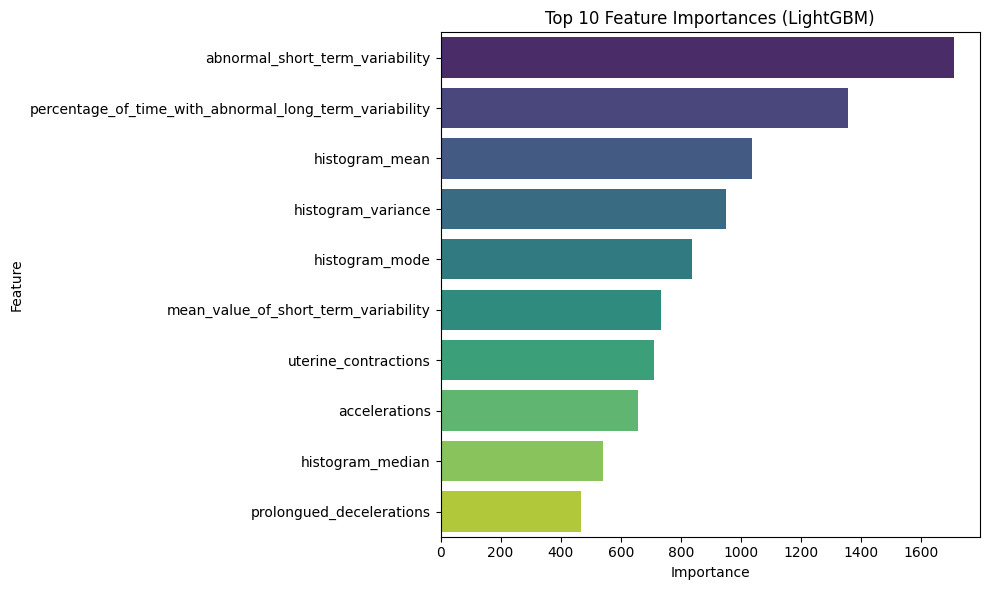

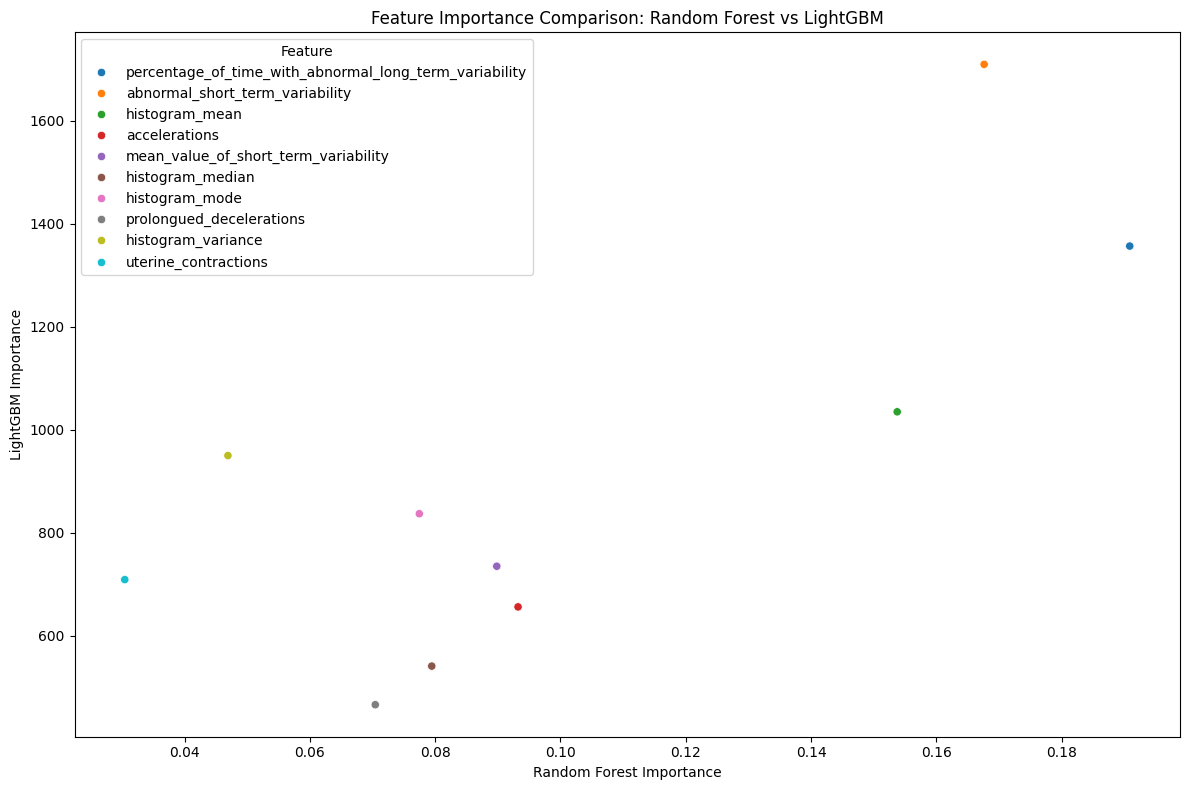

In [30]:

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Traditional ML
import lightgbm as lgb

# Explainable AI
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')  # Update the path if necessary

# Drop irrelevant or SHAP-identified less-important features
features_to_drop = [
    'fetal_movement', 'histogram_width', 'histogram_max',
    'mean_value_of_long_term_variability', 'histogram_number_of_peaks',
    'light_decelerations', 'histogram_tendency', 'histogram_number_of_zeroes',
    'severe_decelerations', 'baseline value', 'histogram_min'
]
data = data.drop(columns=features_to_drop)

# Separate features and target variable
X = data.drop(columns=['fetal_health'])
y = data['fetal_health']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target values so they start from 0
y_train = y_train - 1
y_test = y_test - 1

# Initialize the LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    class_weight='balanced',
    random_state=42
)

# Measure execution time for LightGBM
start_time_lgb = time.time()
# Train the LightGBM model on the resampled and scaled training data
lgb_classifier.fit(X_train_scaled, y_train)
lgb_time = time.time() - start_time_lgb

# Make predictions on the test set
y_pred_lgb = lgb_classifier.predict(X_test_scaled)

# Evaluate LightGBM performance
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=['Normal', 'Suspect', 'Pathological']))
print(f"LightGBM Execution Time: {lgb_time:.2f} seconds")

# Confusion Matrix for LightGBM
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Initialize RandomForest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Measure execution time for Random Forest
start_time_rf = time.time()
# Train the Random Forest model
rf_classifier.fit(X_train_scaled, y_train)
rf_time = time.time() - start_time_rf

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate Random Forest performance
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Suspect', 'Pathological']))
print(f"Random Forest Execution Time: {rf_time:.2f} seconds")

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance Comparison
# Random Forest Feature Importance
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# LightGBM Feature Importance
lgbm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgbm_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()


# Comparative Visualization
importance_comparison = pd.merge(
    rf_importances, lgbm_importances, on='Feature', suffixes=('_RF', '_LGBM')
)

# Scatter Plot Comparison
plt.figure(figsize=(12, 8))
sns.scatterplot(data=importance_comparison, x='Importance_RF', y='Importance_LGBM', hue='Feature')
plt.title('Feature Importance Comparison: Random Forest vs LightGBM')
plt.xlabel('Random Forest Importance')
plt.ylabel('LightGBM Importance')
plt.tight_layout()
plt.show()
